# LoRA Fine tuning Stable Diffusion using Huggingface Diffuers

- 이 노트북에서는 스테이블디퓨전을 개인 데이터 셋에 LoRA를 사용하여 파인튜닝 시키는 과정을 다룸

- 허깅페이스 블로그에 Diffusers에서 제공하는 모델의 로라 파인튜닝 방법이 안오는데 파인튜닝을 위해 미리 작성된 스크립트 파일을 사용하는 방법만 나와 있음
    - https://huggingface.co/blog/lora
    - https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image_lora.py

- pytorch를 기반으로 노트북에 처음부터 하나씩 코딩하면서 파인튜닝하는 방식은 잘 찾아보기 힘듬

- Diffusers에서 제공하는 `train_text_to_image_lora.py`에는 간단하게 논리만 빠르게 파악하고자 하는 학습자에게 필요없는 코드가 너무 많으므로 이를 정리해서 순차적인 노트북 파일을 만들 필요가 있음

- 그런 이유로 이 노트북에서는  `train_text_to_image_lora.py`를 분석하여 최소 필요 코드만으로 빠르게 스테이블 디퓨전을 풀 파인튜닝하는 방법을 기술함

- Full fine tuning과는 다르게 Colab T4에서도 메모리 10GB 정도 쓰면서 잘 학습됨


## Setup

https://github.com/huggingface/diffusers/issues/6160

- Colab에서 실행할 때 A100, V100에서는 잘되나 T4에서 다음과 같은 에러
> RuntimeError: Expected is_sm80 || is_sm90 to be true, but got false.
(Could this error message be improved?  If so, please report an enhancement request to PyTorch.)

- pytorch 2.0으로 다운그레이드
    - https://github.com/huggingface/diffusers/issues/6160



### Pytorch

In [ ]:
!pip uninstall -y torch torchvision torchaudio torchtext

Found existing installation: torch 2.1.0+cu121
Uninstalling torch-2.1.0+cu121:
  Successfully uninstalled torch-2.1.0+cu121
Found existing installation: torchvision 0.16.0+cu121
Uninstalling torchvision-0.16.0+cu121:
  Successfully uninstalled torchvision-0.16.0+cu121
Found existing installation: torchaudio 2.1.0+cu121
Uninstalling torchaudio-2.1.0+cu121:
  Successfully uninstalled torchaudio-2.1.0+cu121
Found existing installation: torchtext 0.16.0
Uninstalling torchtext-0.16.0:
  Successfully uninstalled torchtext-0.16.0


In [ ]:
!pip -q install torch==2.0.0 torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 94.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

- peft를 사용하므로 Diffusers와 Peft 호환성을 위해 github 최신버전으로 설치

### Diffusers

In [ ]:
!git clone https://github.com/huggingface/diffusers.git
%cd diffusers
!pip install .
%cd ..

Cloning into 'diffusers'...
remote: Enumerating objects: 55093, done.
remote: Counting objects: 100% (13780/13780), done.
remote: Compressing objects: 100% (1315/1315), done.
remote: Total 55093 (delta 13259), reused 12525 (delta 12448), pack-reused 41313
Receiving objects: 100% (55093/55093), 36.71 MiB | 15.77 MiB/s, done.
Resolving deltas: 100% (40266/40266), done.
/content/diffusers
Processing /content/diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.27.0.dev0-py3-none-any.whl size=1951060 sha256=41da81c567b7dc17fc70e6f9ff6a766f6e25276eb3beaa521e98634061366eb2
  Stored in directory: /tmp/pip-ephem-wheel-cache-0vtoblg4/wheels/95/c5/3b/e1b4269f8a2584de57e75f949a185b48fc4144e9a91fc9965a
Successfully built diffusers
/content


### Peft

In [ ]:
!git clone https://github.com/huggingface/peft.git
%cd peft
!pip install .
%cd ..

Cloning into 'peft'...
remote: Enumerating objects: 6742, done.
remote: Counting objects: 100% (6742/6742), done.
remote: Compressing objects: 100% (1806/1806), done.
remote: Total 6742 (delta 4460), reused 6568 (delta 4366), pack-reused 0
Receiving objects: 100% (6742/6742), 10.46 MiB | 9.20 MiB/s, done.
Resolving deltas: 100% (4460/4460), done.
/content/peft
Processing /content/peft
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 5.7 MB/s eta 0:00:00
  Created wheel for peft: filename=peft-0.8.2-py3-none-any.whl size=187962 sha256=ba6fd8b9c46031b2b7abc420189378fd2d1d1b8ab548e59d1712f4ca2c5a45b4
  Stored in directory: /tmp/pip-ephem-wheel-cache-94z7x98v/wheels/68/34/9a/bc89c388f31240a90cfdc593223a377c7ee9f751442bd51b9e
Successfully built peft
/content


### Datasets

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.7 MB/s eta 0:00:00


In [ ]:
import torch, transformers, datasets, diffusers, accelerate, peft
torch.__version__, transformers.__version__, datasets.__version__, diffusers.__version__, peft.__version__

('2.0.0+cu117', '4.37.2', '2.17.1', '0.27.0.dev0', '0.8.2')

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torchvision import transforms
import transformers, datasets, diffusers
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from diffusers.optimization import get_scheduler
from diffusers.utils import convert_state_dict_to_diffusers
from diffusers.training_utils import cast_training_params

from peft import LoraConfig
from peft.utils import get_peft_model_state_dict

# tqdm.auto에서 tqdm 로딩하면 중간에 데이터로더가 멈춤, 기다리면 다시 시작되긴 함
# 데이터 로더와 tqdm 충돌 문제
# https://discuss.pytorch.org/t/exception-ignored-in-function-multiprocessingdataloaderiter-del-at/133498
# https://discuss.pytorch.org/t/error-while-multiprocessing-in-dataloader/46845/14
# from tqdm.auto import tqdm
from tqdm import tqdm

from PIL import Image

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 데이터 다운로드

In [ ]:
dataset = datasets.load_dataset("lambdalabs/pokemon-blip-captions")

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 833
    })
})

### 데이터 확인

(1280, 1280)
a very cute looking cartoon character with big eyes


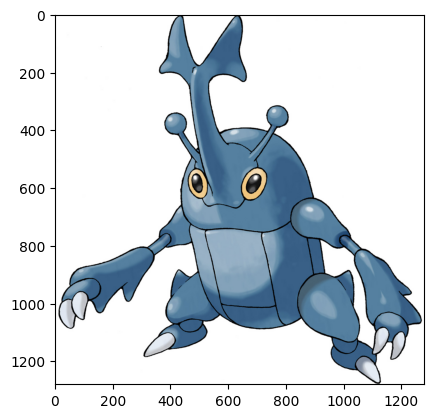

In [ ]:
idx = 140
print(dataset['train'][idx]['image'].size)
print(dataset['train'][idx]['text'])
plt.imshow(np.array(dataset['train'][idx]['image']))
plt.show()

## 필요 모델 로딩

- 노이즈 스케쥴러, 텍스트 토크나이저, 텍스트 인코더, 이미지 오토인코더, unet 모델을 선학습된 상태로 각각 로딩

In [ ]:
PRE_TRAINED_MODEL_NAME="runwayml/stable-diffusion-v1-5"

noise_scheduler = DDPMScheduler.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    subfolder="scheduler"
)

tokenizer = CLIPTokenizer.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    subfolder="tokenizer"
)

# 학습 파라미터 있으나 고정될 것임
text_encoder = CLIPTextModel.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    subfolder="text_encoder"
)

# 학습 파라미터 있으나 고정될 것임
vae = AutoencoderKL.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    subfolder="vae"
)

# 학습 파라미터 있고 파인튜닝 될 것임
unet = UNet2DConditionModel.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    subfolder="unet"
)

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

## 데이터 전처리

### 텍스트 전처리

- 샘플에 로딩된 토크나이저를 적용해 문장을 모두 정수 토큰 아이디로 바꿈

In [ ]:
# 모델에 입력되는 최대 토큰 길이
tokenizer.model_max_length

77

In [ ]:
# 토크나이징 테스트
tokenizer(dataset['train'][idx]['text'],
          max_length=tokenizer.model_max_length,
          padding='max_length',
          truncation=True,
          return_tensors='pt')

{'input_ids': tensor([[49406,   320,  1070,  2242,  1312,  7651,  4009,   593,  1205,  3095,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}

In [ ]:
# 데이터 셋의 한 샘플에 대해서 text컬럼을 토크나이징 해서 되돌리는 함수
def tokenize_captions(examples, caption_column='text', is_train=True):
    captions = []

    for caption in examples[caption_column]:
        # 캡션이 하나인 경우
        if isinstance(caption, str):
            captions.append(caption)
        # 캡션이 하나 이상인 경우 아무거나 하나 선택
        elif isinstance(caption, (list, np.ndarray)):
            # take a random caption if there are multiple
            captions.append(random.choice(caption) if is_train else caption[0])
        else:
            raise ValueError(
                f"Caption column `{caption_column}` should contain either strings or lists of strings."
            )
    inputs = tokenizer(
        captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
    )

    return inputs.input_ids

### 이미지 전처리

- 특별한것 없고 그냥 pytorch에서 제공하는 이미지 증강 기능을 사용

In [ ]:
IMG_SIZE = 512
CENTER_CROP = True
RANDOM_FLIP = True

In [ ]:
# Preprocessing the datasets.
train_transforms = transforms.Compose(
    [
        transforms.Resize(IMG_SIZE, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(IMG_SIZE) if CENTER_CROP else transforms.RandomCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip() if RANDOM_FLIP else transforms.Lambda(lambda x: x),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]), # (0,1)->(-1,1)
    ]
)

### 종합 처리 함수

- 모든 샘플에 대해서 텍스트, 이미지 전처리 함수를 적용할 함수

In [ ]:
def preprocess_train(examples, image_column='image'):
    images = [image.convert("RGB") for image in examples[image_column]]

    # 이미지 전처리
    examples["pixel_values"] = [train_transforms(image) for image in images]

    # 텍스트 전처리
    examples["input_ids"] = tokenize_captions(examples)

    return examples

## 데이터 로더

In [ ]:
def collate_fn(examples):
    # (C, H, W), ..., (C, H, W) -> stack -> (N, C, H, W): N으로 스택
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    # tensor.contiguous()와 동일
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    # {(77,), ..., (77,)}_N개 -> stack -> (N, 77)
    input_ids = torch.stack([example["input_ids"] for example in examples])

    return {"pixel_values": pixel_values, "input_ids": input_ids}

In [ ]:
# 데이터 실시간 변환 적용
train_dataset = dataset["train"].with_transform(preprocess_train)

In [ ]:
# 데이터 컬럼을 확인하면 이시점까지는
# 'image', 'text'만 있고 pixel_values, input_ids 없음
train_dataset.column_names

['image', 'text']

In [ ]:
# 실시간으로 적용되기 때문에 데이터셋 컬럼에는 변환 결과 컬럼이 없고
# 데이터를 가져와야 보임
train_dataset[0].keys()

dict_keys(['image', 'text', 'pixel_values', 'input_ids'])

In [ ]:
BATCH_SIZE = 4
NUM_WORKERS = 4

# DataLoaders creation:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

In [ ]:
# 데이터로더 테스트
train_dataloader_iter = iter(train_dataloader)
mini_batch = next(train_dataloader_iter)

# 이미지 데이터,                  캡션 데이터
mini_batch['pixel_values'].shape, mini_batch['input_ids'].shape

(torch.Size([4, 3, 512, 512]), torch.Size([4, 77]))

In [ ]:
# 데이터로더의 이터레이션 수
len(train_dataloader)

209

In [ ]:
# 참고 text_encoder의 출력
# BaseModelOutputWithPooling 이 되돌려지는데 [0]이 last_hidden_state
# 트랜스포머 인코더의 마지막 히든층 츨력이므로 크기는 (batch size, time step, model dim)
text_encoder(mini_batch['input_ids'])[0].shape

torch.Size([4, 77, 768])

## 모델 준비

In [ ]:
# FP16을 AMP으로 적용하기 위한 세팅

# weight_dtype = torch.float32
weight_dtype = torch.float16 # half precision

In [ ]:
# unet, vae와 텍스트 인코더는 미세조정에서 학습되지 않음
unet.requires_grad_(False)
vae.requires_grad_(False)
text_encoder.requires_grad_(False);

#### LoRA 어댑터 준비

In [ ]:
LORA_RANK = 4

# Freeze the unet parameters before adding adapters
for param in unet.parameters():
    param.requires_grad_(False)

unet_lora_config = LoraConfig(
    r=LORA_RANK,
    lora_alpha=LORA_RANK,
    init_lora_weights="gaussian",
    target_modules=["to_k", "to_q", "to_v", "to_out.0"],
)

In [ ]:
text_encoder.to(device);
vae.to(device);
unet.to(device);

In [ ]:
# Add adapter and make sure the trainable params are in float32.
unet.add_adapter(unet_lora_config)

# 원 스크립트 소스는 모델 가중치를 모두 FP16으로 캐스팅하는데
# 여기서는 FP16으로 캐스팅하지 않고 AMP 사용하기 때문에
# 여기서는 이 부분이 필요 없을 것으로 생각되나
# 그냥 두었음
if weight_dtype == torch.float16:
    # only upcast trainable parameters (LoRA) into fp32
    cast_training_params(unet, dtype=torch.float32)

lora_layers = filter(lambda p: p.requires_grad, unet.parameters())

## 옵티마이저 & 학습률 스케쥴러

In [ ]:
EPOCHS = 30
LEARNING_RATE = 1e-04

optimizer = torch.optim.AdamW(
        lora_layers,
        lr=LEARNING_RATE,
        # betas=(args.adam_beta1, args.adam_beta2),
        # weight_decay=args.adam_weight_decay,
        # eps=args.adam_epsilon,
    )

In [ ]:
lr_scheduler = get_scheduler(
        'linear',
        optimizer=optimizer,
        num_warmup_steps=500,
        num_training_steps=EPOCHS * len(train_dataloader)
    )

## 학습 루프

In [ ]:
# 학습 요소들의 세팅값 확인

# 모델이 추정하는 타겟은 epsilon,       이미지 디코더 스케일 상수
noise_scheduler.config.prediction_type, vae.config.scaling_factor

('epsilon', 0.18215)

In [ ]:
# APM
# - True: 1m30s(RTX3090)/epoch, 5m00s(T4)/epoch,
# - False: 테스트 안해봄

use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
prediction_type = None # 'epsilon'  or 'v_prediction'

train_losses = []

for epoch in range(EPOCHS):
    for step, batch in enumerate(tqdm(train_dataloader)):
        # T4에서 amp autocast가 호환이 안됨
        with torch.autocast(device_type=device, dtype=weight_dtype, enabled=use_amp):
            # Convert images to latent space
            latents = vae.encode(
                batch["pixel_values"].to(device)
                # batch["pixel_values"].to(device, dtype=weight_dtype)
            ).latent_dist.sample()
            latents = latents * vae.config.scaling_factor

            # Sample noise that we'll add to the latents
            noise = torch.randn_like(latents)

            bsz = latents.shape[0]
            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
            timesteps = timesteps.long()

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Get the text embedding for conditioning, [0]: last_hidden_state
            encoder_hidden_states = text_encoder(batch["input_ids"].to(device) )[0]

            # 노이즈 스케쥴러에 예측 타입이 노이즈인지 이미지인지에 따라 타겟 설정
            if prediction_type is not None:
                # set prediction_type of scheduler if defined
                noise_scheduler.register_to_config(prediction_type=prediction_type)

            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(latents, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

            # Predict the noise residual and compute loss
            model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

            loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")


        with torch.no_grad():
            train_losses.append(loss.item())

        # loss.backward()
        # optimizer.step()
        # lr_scheduler.step()
        # optimizer.zero_grad()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        lr_scheduler.step()
        optimizer.zero_grad()

    # print loss
    avg_loss = sum(train_losses[-100:])/100
    print(f'Finished epoch {epoch+1}. Average of the last 100 loss values: {avg_loss:05f}')


100%|██████████| 209/209 [05:02<00:00,  1.45s/it]


Finished epoch 1. Average of the last 100 loss values: 0.054234


100%|██████████| 209/209 [05:07<00:00,  1.47s/it]


Finished epoch 2. Average of the last 100 loss values: 0.048702


100%|██████████| 209/209 [05:07<00:00,  1.47s/it]


Finished epoch 3. Average of the last 100 loss values: 0.052327


100%|██████████| 209/209 [05:08<00:00,  1.47s/it]


Finished epoch 4. Average of the last 100 loss values: 0.049837


100%|██████████| 209/209 [05:07<00:00,  1.47s/it]


Finished epoch 5. Average of the last 100 loss values: 0.050628


100%|██████████| 209/209 [05:07<00:00,  1.47s/it]


Finished epoch 6. Average of the last 100 loss values: 0.053080


100%|██████████| 209/209 [05:07<00:00,  1.47s/it]


Finished epoch 7. Average of the last 100 loss values: 0.054024


100%|██████████| 209/209 [05:07<00:00,  1.47s/it]


Finished epoch 8. Average of the last 100 loss values: 0.048962


100%|██████████| 209/209 [05:07<00:00,  1.47s/it]


Finished epoch 9. Average of the last 100 loss values: 0.050139


100%|██████████| 209/209 [05:07<00:00,  1.47s/it]


Finished epoch 10. Average of the last 100 loss values: 0.050103


100%|██████████| 209/209 [05:07<00:00,  1.47s/it]


Finished epoch 11. Average of the last 100 loss values: 0.051134


100%|██████████| 209/209 [05:07<00:00,  1.47s/it]


Finished epoch 12. Average of the last 100 loss values: 0.049061


100%|██████████| 209/209 [05:07<00:00,  1.47s/it]


Finished epoch 13. Average of the last 100 loss values: 0.050965


100%|██████████| 209/209 [05:08<00:00,  1.47s/it]


Finished epoch 14. Average of the last 100 loss values: 0.049548


100%|██████████| 209/209 [05:07<00:00,  1.47s/it]


Finished epoch 15. Average of the last 100 loss values: 0.055948


100%|██████████| 209/209 [05:08<00:00,  1.47s/it]


Finished epoch 16. Average of the last 100 loss values: 0.049579


100%|██████████| 209/209 [05:08<00:00,  1.47s/it]


Finished epoch 17. Average of the last 100 loss values: 0.053901


100%|██████████| 209/209 [05:07<00:00,  1.47s/it]


Finished epoch 18. Average of the last 100 loss values: 0.058163


100%|██████████| 209/209 [05:07<00:00,  1.47s/it]


Finished epoch 19. Average of the last 100 loss values: 0.054952


100%|██████████| 209/209 [05:08<00:00,  1.47s/it]


Finished epoch 20. Average of the last 100 loss values: 0.053816


100%|██████████| 209/209 [05:07<00:00,  1.47s/it]


Finished epoch 21. Average of the last 100 loss values: 0.052957


100%|██████████| 209/209 [05:07<00:00,  1.47s/it]


Finished epoch 22. Average of the last 100 loss values: 0.048424


100%|██████████| 209/209 [05:07<00:00,  1.47s/it]


Finished epoch 23. Average of the last 100 loss values: 0.054871


100%|██████████| 209/209 [05:08<00:00,  1.48s/it]


Finished epoch 24. Average of the last 100 loss values: 0.054620


100%|██████████| 209/209 [05:08<00:00,  1.47s/it]


Finished epoch 25. Average of the last 100 loss values: 0.047881


100%|██████████| 209/209 [05:08<00:00,  1.47s/it]


Finished epoch 26. Average of the last 100 loss values: 0.048070


100%|██████████| 209/209 [05:07<00:00,  1.47s/it]


Finished epoch 27. Average of the last 100 loss values: 0.049714


100%|██████████| 209/209 [05:08<00:00,  1.47s/it]


Finished epoch 28. Average of the last 100 loss values: 0.045530


100%|██████████| 209/209 [05:08<00:00,  1.47s/it]


Finished epoch 29. Average of the last 100 loss values: 0.049707


100%|██████████| 209/209 [05:08<00:00,  1.47s/it]

Finished epoch 30. Average of the last 100 loss values: 0.049470


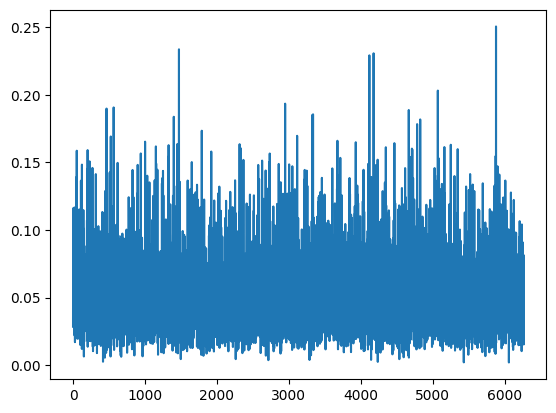

In [ ]:
plt.plot(train_losses)
plt.show()

In [ ]:
import pandas as pd

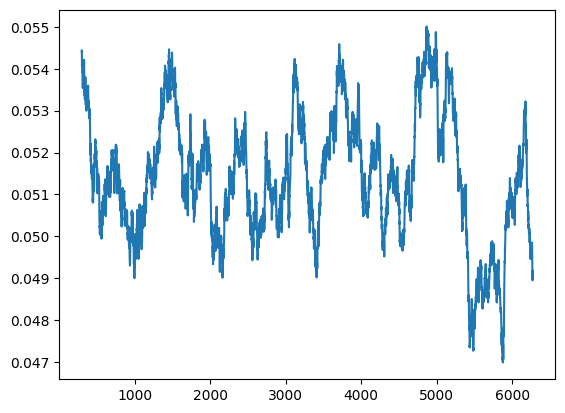

In [ ]:
losses_sr = pd.Series(train_losses)
loss_mv = losses_sr.rolling(window=300).mean()

plt.plot(loss_mv)

## 이미지 생성

### 옵션 1: 직접 생성

In [ ]:
prompt = ["a very cute looking cartoon character with big eyes"]

height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion

num_inference_steps = 20  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance

generator = torch.manual_seed(2)  # Seed generator to create the initial latent noise

batch_size = len(prompt)

In [ ]:
text_input = tokenizer(
    prompt, max_length=tokenizer.model_max_length,
    padding="max_length", truncation=True, return_tensors="pt"
)

# 시퀀스 길이 77
print(len(text_input['input_ids'][0]))

# 토큰화 결과
text_input

77


{'input_ids': tensor([[49406,   320,  1070,  2242,  1312,  7651,  4009,   593,  1205,  3095,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}

In [ ]:
with torch.no_grad():
    text_embeddings = text_encoder(text_input['input_ids'].to(device))[0]

# 각 토큰은 768차원 벡터로 임베딩
text_embeddings.shape

torch.Size([1, 77, 768])

In [ ]:
max_length = text_input['input_ids'].shape[-1]

# 모두 공백인 ""으로 채워서 텍스트 컨디션을 없는 것으로 만듬
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")

uncond_embeddings = text_encoder(uncond_input['input_ids'].to(device))[0]

In [ ]:
# (1, 77, 768), (1, 77, 768) => (2, 77, 768)
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# 구체적인 조건이 있는것과 그냥 깡통 조건(모두 공백인)이 같이 묶임
text_embeddings.shape

torch.Size([2, 77, 768])

In [ ]:
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
).to(device)

In [ ]:
# 타임스탭 세팅
noise_scheduler.set_timesteps(num_inference_steps)
noise_scheduler.timesteps

tensor([951, 901, 851, 801, 751, 701, 651, 601, 551, 501, 451, 401, 351, 301,
        251, 201, 151, 101,  51,   1])

In [ ]:
lora_scale = 0.9

for t in tqdm(noise_scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(
            latent_model_input,
            t,
            encoder_hidden_states=text_embeddings,
            cross_attention_kwargs={"scale": lora_scale},
        ).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    # CFG eq(6)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = noise_scheduler.step(noise_pred, t, latents).prev_sample

100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


In [ ]:
# scale and decode the image latents with vae
#  0.18215는 SD개발자들이 찾아낸 디코딩이 잘되기 위한 상수
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

In [ ]:
image.shape

torch.Size([1, 3, 512, 512])

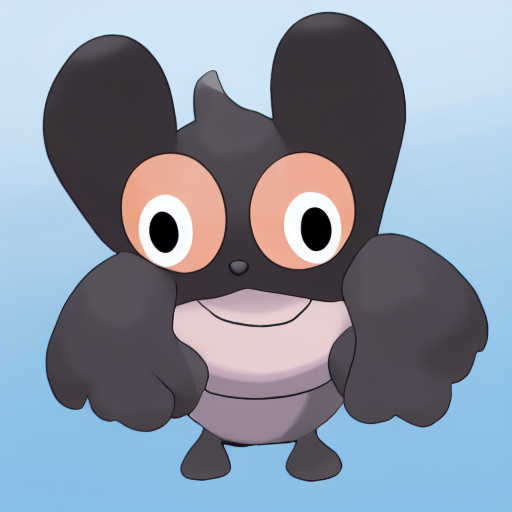

In [ ]:
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image

### 옵션2: 파이프라인 사용

In [ ]:
from diffusers import StableDiffusionPipeline

In [ ]:
pipeline = StableDiffusionPipeline.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    text_encoder=text_encoder,
    vae=vae,
    unet=unet, # 미세 조정된 네트워크
)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
pipeline.to(device);

  0%|          | 0/20 [00:00<?, ?it/s]

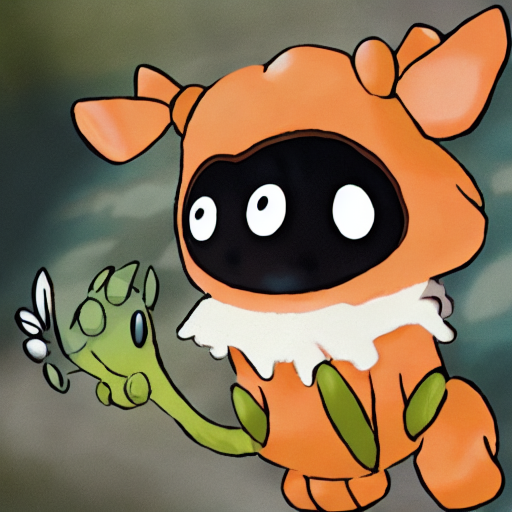

In [ ]:
lora_scale = 0.9
pipeline_output = pipeline(
    prompt=["a very cute looking cartoon character with big eyes"],
    num_inference_steps=20,
    cross_attention_kwargs={"scale": lora_scale},
    generator=torch.manual_seed(101)
)
pipeline_output.images[0]


  0%|          | 0/20 [00:00<?, ?it/s]

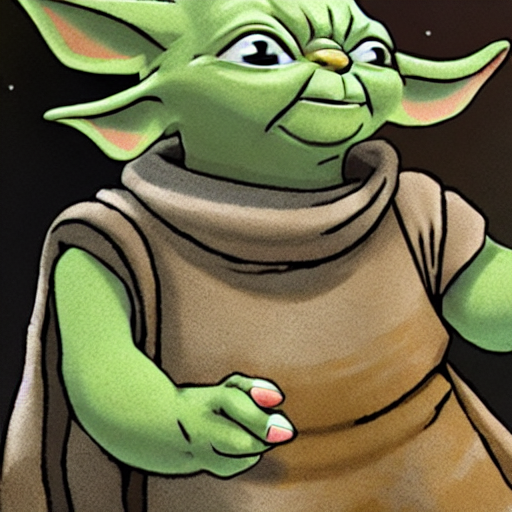

In [ ]:
lora_scale = 0.9

pipeline_output = pipeline(
    prompt=["Yoda"],
    num_inference_steps=20,
    cross_attention_kwargs={"scale": lora_scale},
    generator=torch.manual_seed(101)
)
pipeline_output.images[0]

## 학습된 모델 파이프라인 저장

### 로컬 저장

In [ ]:
# pipeline.save_pretrained("./lora_finetuning_save")

In [ ]:
# unet_lora_state_dict = convert_state_dict_to_diffusers(get_peft_model_state_dict(unet))

In [ ]:
# list(unet_lora_state_dict.keys())[:5]

In [ ]:
# pytorch_lora_weights.safetensors 를 저장
# StableDiffusionPipeline.save_lora_weights(
#     save_directory="./lora_finetuning_weights",
#     unet_lora_layers=unet_lora_state_dict,
#     safe_serialization=True,
# )

### push to Hub

In [ ]:
# https://huggingface.co/docs/transformers/model_sharing
# from huggingface_hub import notebook_login
# notebook_login()

In [ ]:
# pipeline.push_to_hub("stable-diffusion-v1-5-finetune-pokemon-blip")

## 참고 링크

- 로라 파인튜닝 블로그: https://huggingface.co/blog/lora

- 데이터 셋: https://huggingface.co/datasets/lambdalabs/pokemon-blip-captions

- 파인튜닝 스크립트 소스: https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image_lora.py



- Pytorch AMP 도움말: https://pytorch.org/tutorials/recipes/recipes/amp_recipe.html


- Pytorch AMP 블로그: https://pytorch.org/blog/what-every-user-should-know-about-mixed-precision-training-in-pytorch/